In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns 

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".97"})

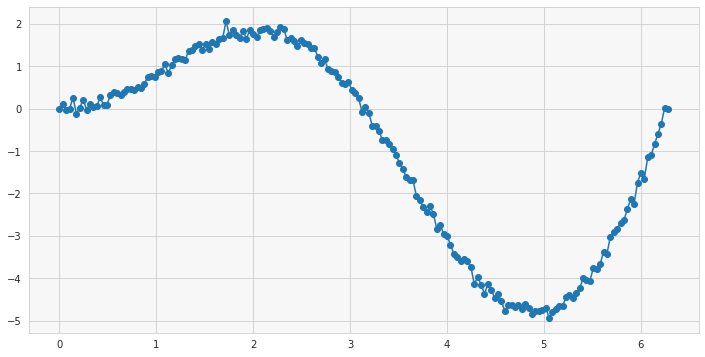

In [41]:
N = 180
error = .1

x = torch.linspace(0, np.pi*2, N) 
y = torch.sin(x)*x + torch.randn(N)*error

plt.plot(x.detach(), y, '-o')

In [9]:
lentrain = 3
dn = 1
dx = (x[1] - x[0])*dn
#params = init_params(lentrain)

# Device a 'train set' - do not gen confused by the fact that the y values are used in the training..:
x_train = x.reshape(-1, lentrain)
y_train = y.reshape(-1, lentrain)
# This is used to train:
X_train = torch.cat((x_train, y_train), 1)[:-1]
y_train = y_train[1:, dn-1].reshape(-1, 1)

# These are the actual points that are predicted:
x_train = x_train[1:, dn-1].reshape(-1, 1)


In [31]:
def simple_model_predict(params, X_train):
    """
    Device a simple model that tries to predict the value of y at x + dx.
    The y[-1] is assumed to be at y[x] and x = 0,1,2,....
    """
    
    x = X_train[:, :lentrain]
    y = X_train[:, lentrain:]
    
    def get_derivs_():
        """
        Return the derivatives of y w.r.t. x
        """
        dydx = (y[:, -2] - y[:, -1])/(x[:, -2] - x[:, -1]) #np.gradient(y, x)
        dydx2 =(y[:, -3] - y[:, -2])/(x[:, -3] - x[:, -2]) #np.gradient(y, x)

        d2ydx2 = 2*(dydx - dydx2)/(x[:, -3] - x[:, -1]) #np.gradient(dydx, x)
        return y[:, -1], dydx, d2ydx2
    
        
    y0, dydx, d2ydx2 = get_derivs_()
    y_pred = params[0]*y0 + params[1]*dydx*dx + params[2]*d2ydx2*dx**2 
        
    return y_pred.reshape(-1, 1)

    

def rms_loss(y_true, y_pred):
    
    if y_true.shape != y_pred.shape:
        print(y_true.shape)
        print(y_pred.shape)
        raise TypeError('The sizes of arrays do not match')
    
    return ((y_true - y_pred)**2).mean()

def update_params(lr, params): 
    if isinstance(params, tuple):
        for p in params:
            p.data -= lr * p.grad.data
            p.grad = None #.zero_()
        return params
    else:
        params.data -= lr * params.grad.data
        params.grad = None
        return params
    
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

def plot_estimate(preds, params=None, niter=None):
    """
    Plot estiamate given by model and compare with actual data:
    """
    
    plt.plot(x.detach(), y)
    plt.scatter(x_train.detach(), preds.detach())
    
    title = 'Loss: {:.5f}\n'.format(rms_loss(y_train, preds))
    if params is not None:
        title += 'params: {}\n'.format(params.data)
    if niter is not None:
        title += 'niter: {}'.format(niter)
    
    plt.title(title)
    
    plt.show()

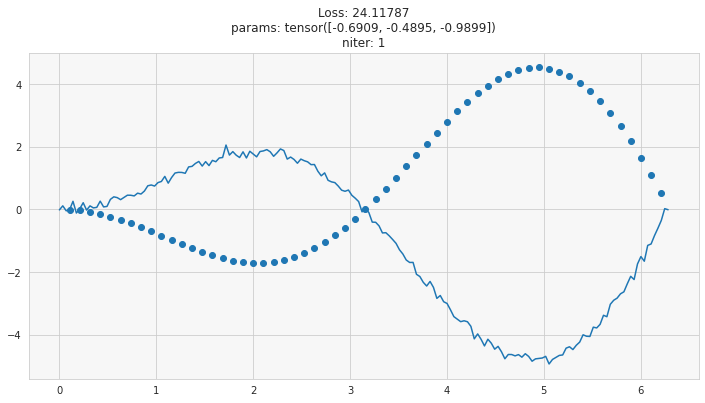

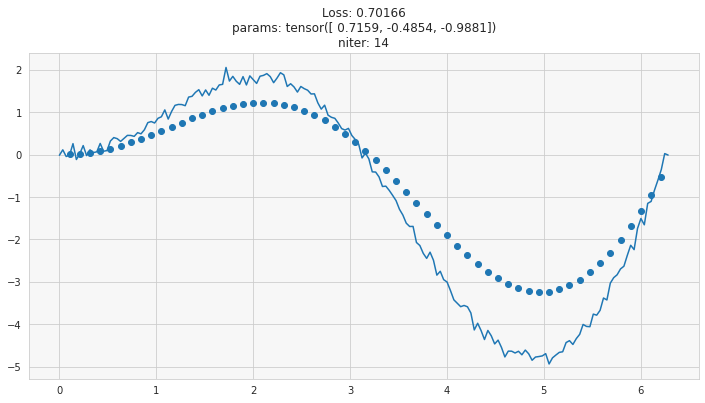

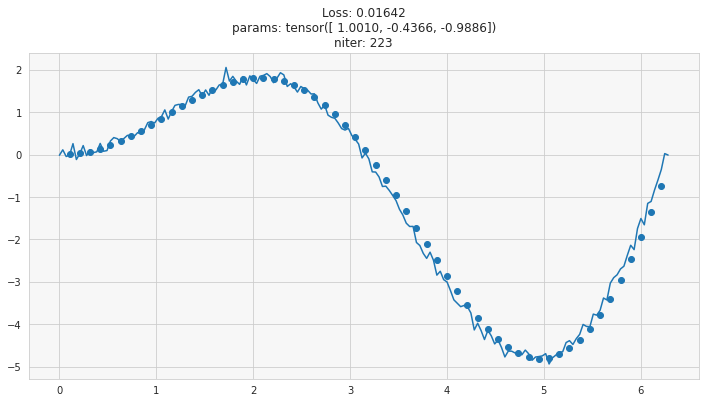

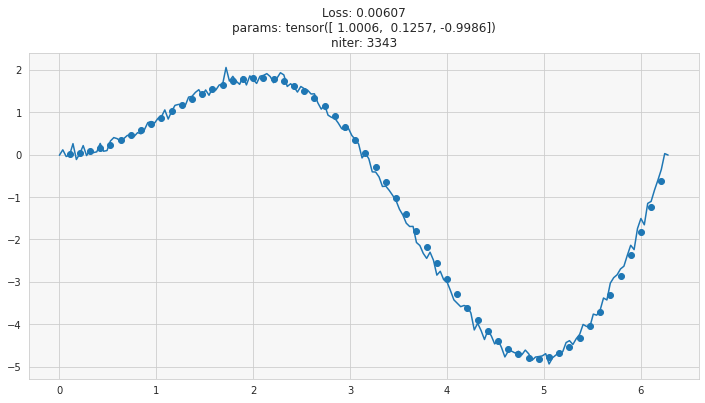

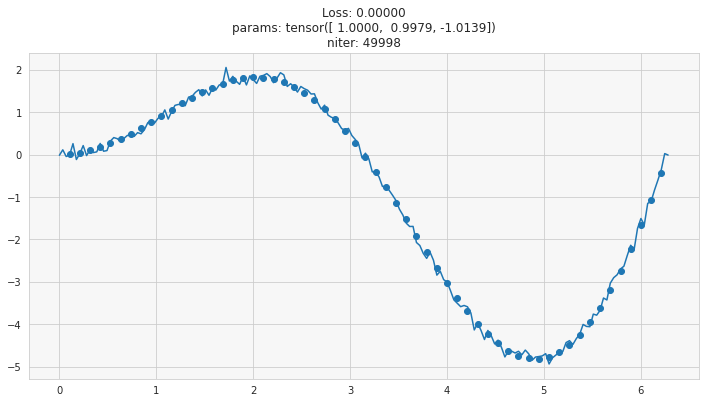

In [43]:
params = init_params(3)
N_iter = 50000
nplots = 5
plot_at_iter = np.logspace(0, np.log2(N_iter-1), nplots, base=2).astype(int)

for j in range(N_iter):
    preds = simple_model_predict(params, X_train)
    loss = rms_loss(y_train, preds)
    loss.backward()
    
    params = update_params(1e-2, params)
    
    if j in plot_at_iter:
        plot_estimate(preds, params, j)

In [44]:
w1 = init_params((3, 10))
b1 = init_params(10)
w2 = init_params((10, 10))
b2 = init_params(10)
w3 = init_params((10, 1))
b3 = init_params(1)

params = (w1, b1, w2, b2, w3, b3)

def nnet_predict(params, X_train):
    
    w1, b1, w2, b2, w3, b3 = params
    y = X_train[:, lentrain:]
    
    res = y@w1 + b1
    res = res.max(torch.tensor(0.0))
    res = res@w2 + b2
    res = res.max(torch.tensor(0.0))
    res = res@w3 + b3
    
    return res

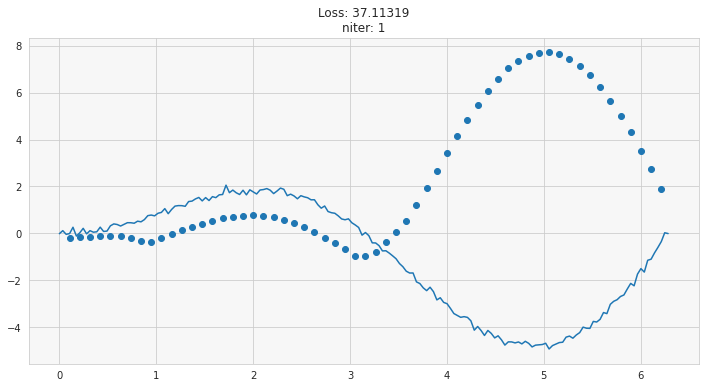

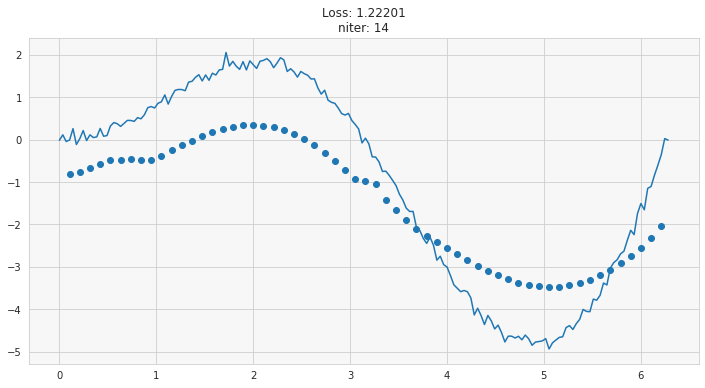

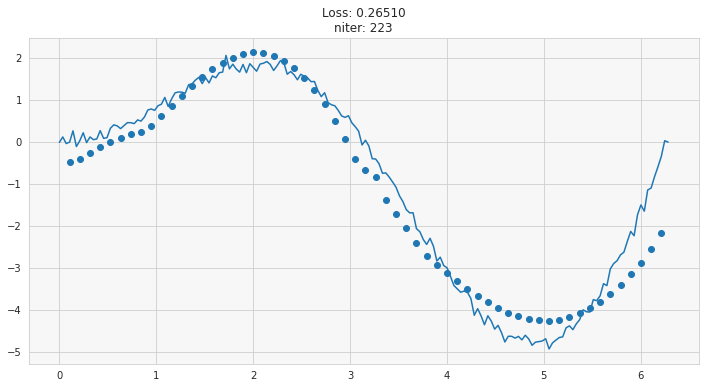

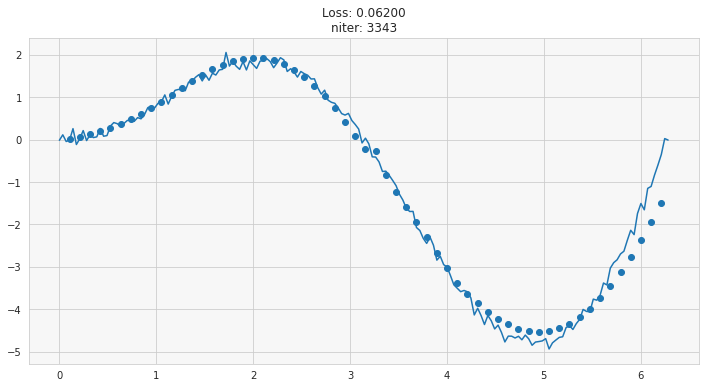

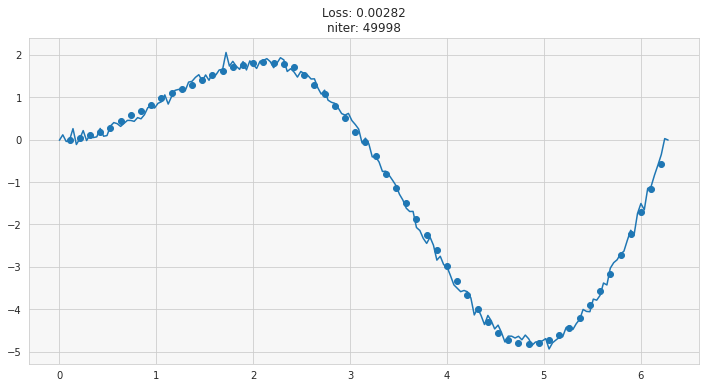

In [45]:

    
for _ in range(N_iter):
    
    preds = nnet_predict(params, X_train)
    loss = rms_loss(y_train, preds)
    loss.backward()
    update_params(1e-3, params)
    
    if _ in plot_at_iter: 
    
        plot_estimate(preds, niter=_)
    

### Using fastai

First we need to load data:

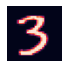

In [175]:
from fastai.vision.all import *
import torch.nn as nn

path = untar_data(URLs.MNIST_SAMPLE)

# Load:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

# Put in lists:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

# Stack into tensors:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# Make a train set
X_train = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
y_train = tensor([1]*len(threes) + [0]*len(sevens)) #.unsqueeze(1)

# Finally combine the X and y into (X, y) tuples:
dset = list(zip(X_train, y_train))

#Make fastai dataloader:
dl = DataLoader(dset, batch_size=256)

# The whole above business for valid set:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255
X_valid = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28) 
y_valid = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)) #.unsqueeze(1)
valid_dset = list(zip(X_valid, y_valid))
valid_dl = DataLoader(valid_dset, batch_size=256)

# Dataloaders are provded by fastai and they ease the delivery of data to learners:
dls = DataLoaders(dl, valid_dl)

show_image(three_tensors[1]);

#### Here we build a simple model using fastai and pytorch to learn and then predict in the above dsets:

In [176]:
lr = 1e-3

# Pytorch provides a linear model: 
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 2),
    # The softmax is taken at the cross entropy
)

# We use cross entropy as the loss function - this is the negative log likelihood of the class probabilities.
def cross_e(predictions, targets):
    pred = F.softmax(predictions, dim=1)
    return F.nll_loss(pred, targets)

# Learners can take care of the whole learning process. Convenient:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=cross_e, metrics=accuracy)

# The you call the fit:
learn.fit(50, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,-0.763254,-0.564974,0.504416,00:00
1,-0.887233,-0.784281,0.814524,00:00
2,-0.937173,-0.890007,0.913641,00:00
3,-0.957832,-0.924759,0.939647,00:00
4,-0.967352,-0.941076,0.955348,00:00
5,-0.972218,-0.950407,0.962218,00:00
6,-0.975032,-0.956365,0.966634,00:00
7,-0.976892,-0.960450,0.969578,00:00
8,-0.978260,-0.963423,0.971050,00:00
9,-0.979336,-0.965682,0.971050,00:00
